In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

#### The dataset consists of 10 000 data points stored as rows with 14 features in columns

- UID: unique identifier ranging from 1 to 10000
- productID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
- air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise
- torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
- tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
- 'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.

### Loading data

In [30]:
raw_data= pd.read_csv("predictive_maintenance.csv")

df=raw_data.copy()

df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


In [31]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [33]:
#checking unique values for 'UDI' and 'product ID'

print("Unique values for UDI",df['UDI'].nunique())

print("Unique values for",df['Product ID'].nunique())

Unique values for UDI 10000
Unique values for 10000


In [34]:
# dropping udi and product ID
df.drop(['UDI','Product ID'],axis=1, inplace=True)

In [35]:
#Change the names of the columns
df = df.rename(mapper={'Air temperature [K]': 'Air temperature',
                       'Process temperature [K]': 'Process temperature',
                       'Rotational speed [rpm]': 'Rotational speed',
                       'Torque [Nm]': 'Torque', 
                       'Tool wear [min]': 'Tool wear'}, axis=1)

In [36]:
#different types of failures

df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

###### We can see the target variable is highly unbalanced.

In [39]:
#checking other target variable

df[["Tool wear",'Target']].value_counts()

Tool wear  Target
0          0         117
2          0          67
5          0          62
7          0          58
59         0          57
                    ... 
49         1           1
154        1           1
199        1           1
5          1           1
253        1           1
Length: 415, dtype: int64

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 10000 non-null  object 
 1   Air temperature      10000 non-null  float64
 2   Process temperature  10000 non-null  float64
 3   Rotational speed     10000 non-null  int64  
 4   Torque               10000 non-null  float64
 5   Tool wear            10000 non-null  int64  
 6   Target               10000 non-null  int64  
 7   Failure Type         10000 non-null  object 
dtypes: float64(3), int64(3), object(2)
memory usage: 625.1+ KB


In [42]:
# value count for all categorical columns

cat_cols= df.select_dtypes(include=object).columns.tolist()

(pd.DataFrame(df[cat_cols].melt(var_name='column', value_name='value').value_counts())
 .rename(columns={0:'counts'})
 .sort_values(by=['column','counts']))

counts
column       value                           
Failure Type Random Failures               18
             Tool Wear Failure             45
             Overstrain Failure            78
             Power Failure                 95
             Heat Dissipation Failure     112
             No Failure                  9652
Type         H                           1003
             M                           2997
             L                           6000

### Studying target variables

###### There are two target variables: 'Target' & 'Failure type'

In [43]:
df_failure=df[df['Target']==1]

df_failure['Failure Type'].value_counts()

Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: Failure Type, dtype: int64

###### As we can see "9" observations are classified as "no failure" even if they are classified "Failure" in "target"

In [44]:
df_failure[df_failure['Failure Type'] == 'No Failure']

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type
1437,H,298.8,309.9,1439,45.2,40,1,No Failure
2749,M,299.7,309.2,1685,28.9,179,1,No Failure
4044,M,301.9,310.9,1419,47.7,20,1,No Failure
4684,M,303.6,311.8,1421,44.8,101,1,No Failure
5536,M,302.3,311.8,1363,54.0,119,1,No Failure
5941,L,300.6,310.7,1438,48.5,78,1,No Failure
6478,L,300.5,309.8,1663,29.1,145,1,No Failure
8506,L,298.4,309.6,1710,27.3,163,1,No Failure
9015,L,297.2,308.1,1431,49.7,210,1,No Failure


###### So as we dont know the correct reading it is better to drop this observations

In [45]:
df.drop(df_failure[df_failure['Failure Type'] == 'No Failure'].index, axis=0, inplace=True)

Lets check for "Target" variable equal to zero(no failure):

In [46]:
df_failure=df[df['Target']==0]

df_failure['Failure Type'].value_counts()

No Failure         9643
Random Failures      18
Name: Failure Type, dtype: int64

###### Here also some misclassification if observed
Dropping this observations too

In [53]:
df.drop(df_failure[df_failure['Failure Type'] == 'Random Failures'].index, axis=0, inplace=True)

KeyError: '[1221, 1302, 1748, 2072, 2559, 3065, 3452, 5471, 5489, 5495, 5509, 5553, 5639, 6091, 6913, 6960, 7488, 7868] not found in axis'

27 instaces were removed (0.27% of the entire dataset). Of which:

- 9 belonged to class Failure in 'Target' variable and Not failure in target 'Failure Type'
- 18 belonged to class Not failure in 'Target' variable and Random failures in target 'Failure Type'

In [54]:
# We can check that all 27 instances were removed from the dataset:
df.shape[0]

9973

In [55]:
# Let's reset the index
df.reset_index(inplace=True, drop=True)

## EDA

#### Correlation

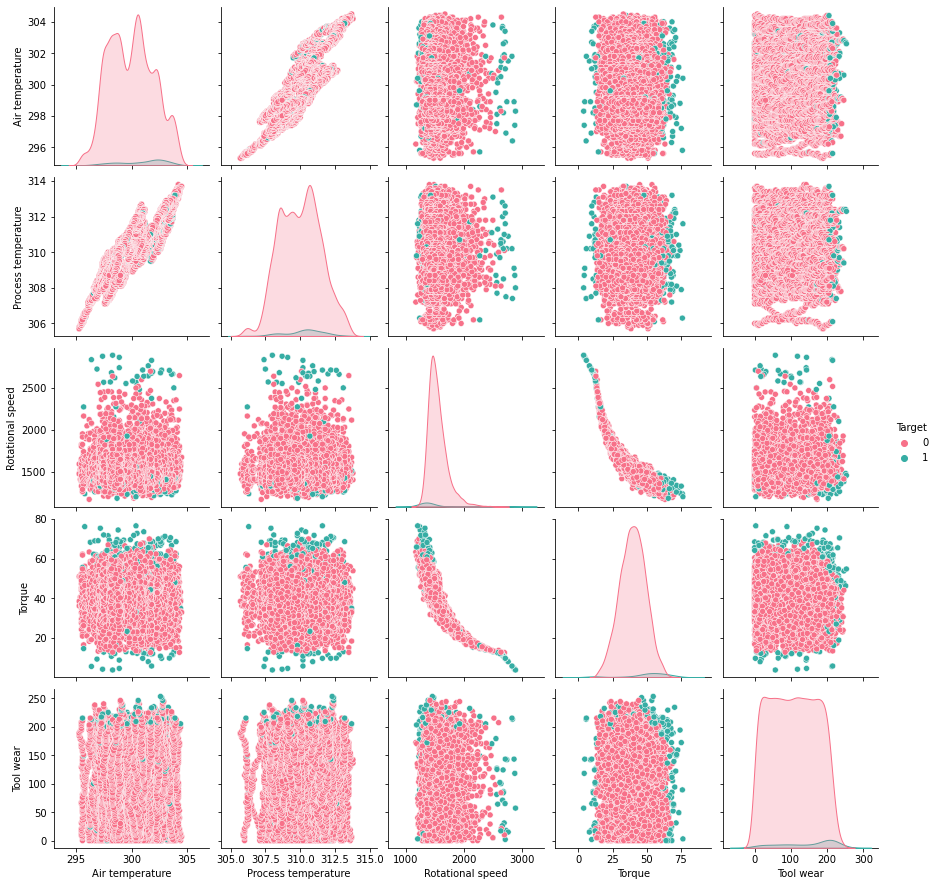

In [56]:
sns.pairplot(df, hue='Target', palette='husl')

#### Insights:

- Torque and rotational speed are highly correlated.
- Process temperature and air temperature are also highly correlated.
- We immediately see that failures take place for extreme values of some features, i.e., the machinery fails either for the lowest or largest values of torque and rotational speed. 
- This is easily spotted in the graph since the green dots are far apart for those features. So, there is a range for normal conditions in which the machines operate, and above or under this range, they tend to fail.

#### Correlation heatmap

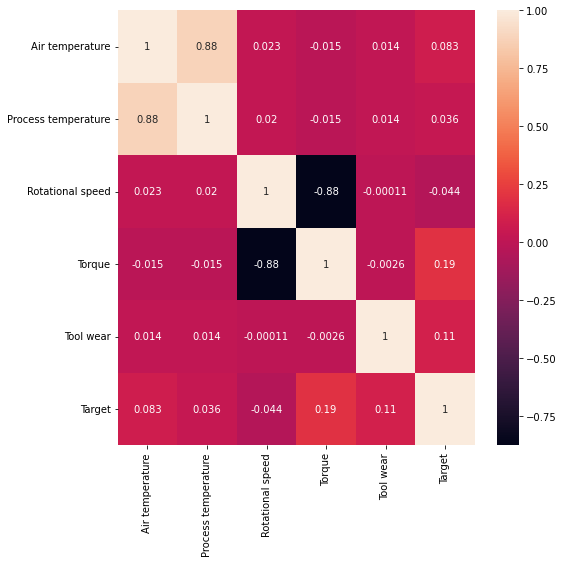

In [59]:
plt.figure(figsize=(8,8))

sns.heatmap(df.corr(), annot=True)
plt.show()

#### Percentage of failure wrt product type

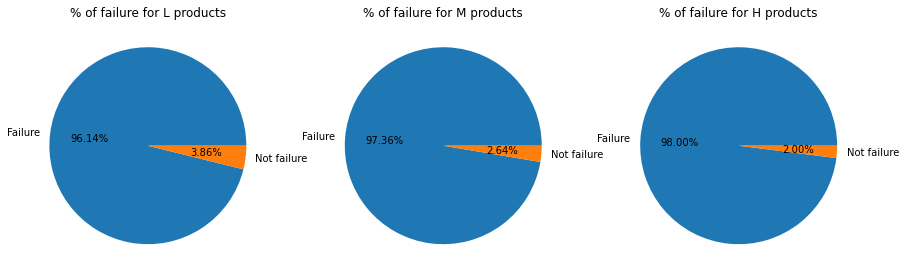

In [69]:
fig, axes= plt.subplots(1,3, figsize=[15,5])
axes.flatten()

j=0

for i in ["L",'M','H']:
    df_prod_type= df[df['Type']==i]
    axes[j].pie(df_prod_type['Target'].value_counts(), labels=['Failure','Not failure'],autopct='%1.2f%%')
    axes[j].set_title("% of failure for " + i + " products")
    j+=1

#### Exploring features for each type of failure

Text(0.5, 1.0, 'Excluding class no failure')

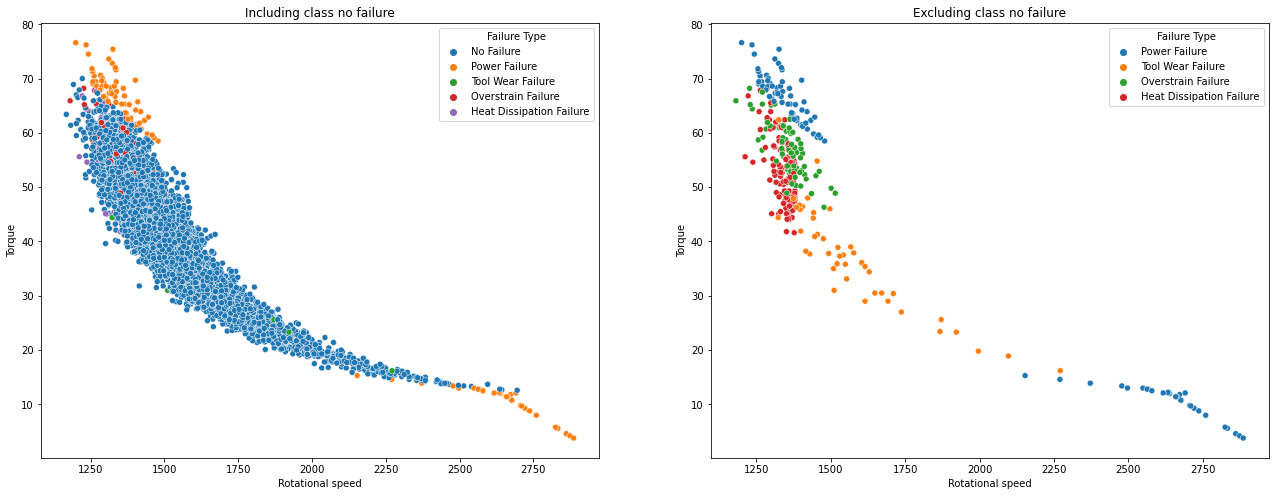

In [70]:
fig, ax= plt.subplots (1,2, figsize=[22,8])

plt.title('Rotational speed VS Torque wrt Failure Type')

sns.scatterplot(data=df, x='Rotational speed', y='Torque', hue='Failure Type',ax=ax[0])

sns.scatterplot(data=df[df['Target']==1], x='Rotational speed', y='Torque', hue='Failure Type',ax=ax[1])

ax[0].set_title('Including class no failure')
ax[1].set_title('Excluding class no failure')

#### Some insights:

- Power failure happens both for lower and higher rotational speed/torque. It is the type of failure with the highest rotational speed (over 2500rpm) and lowest torque (below around 15Nm). In other others, above and below these thresholds only power failures occur.
- Between torques 16Nm and 41Nm all failures are tool wear.
- Overstrain failures take place with torques ranging from around 47 and 68Nm) and rotational speeds from 1200 to 1500rpm approximately.
- For heat dissipation failures, the torque range is smalller and the rotational speed range is bigger, compared to overstrain failures.

### Distribution

-----SKEWNESS----
Air temperature skewness= 0.12
Process temperature skewness= 0.02
Rotational speed skewness= 1.99
Torque skewness= -0.01
Tool wear skewness= 0.03
---------------


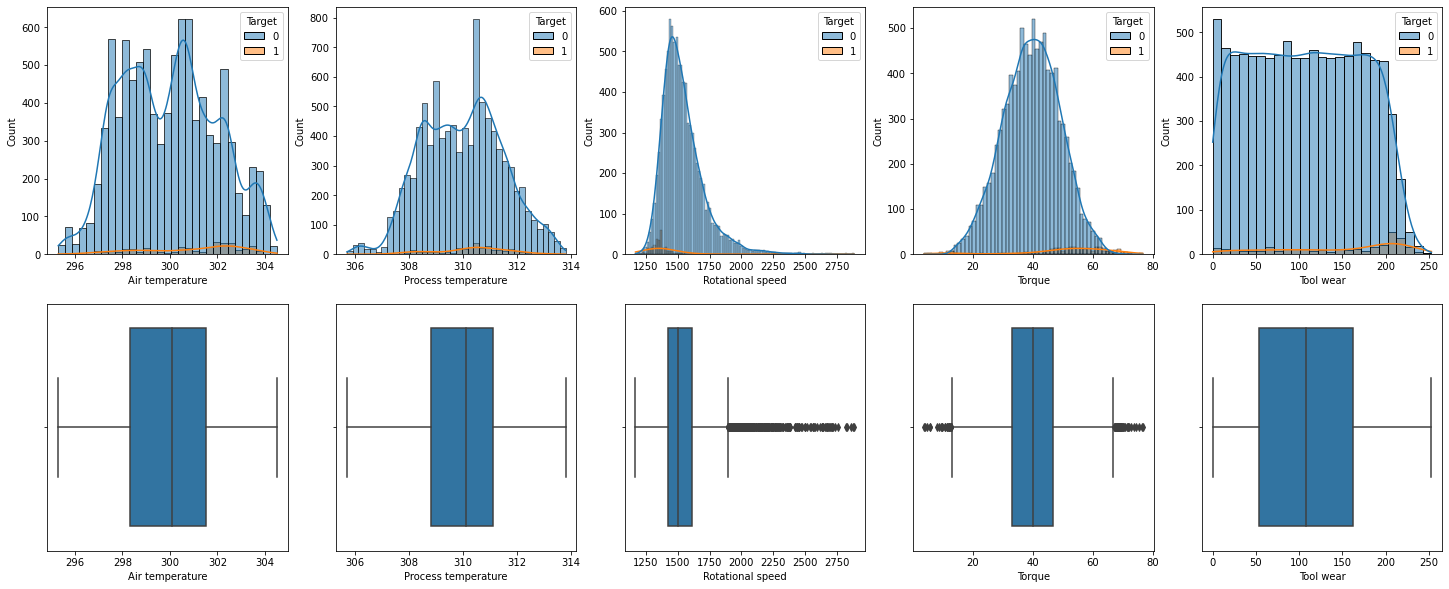

In [73]:
print("-----SKEWNESS----")

fig,axes=plt.subplots(2,5, figsize=[25,10])

j=0

for i in ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']:
    sns.histplot(data=df,x=i, kde=True, ax=axes[0,j], hue='Target')
    
    sns.boxplot(data=df, x=i, ax=axes[1,j])
    
    j+=1
    print('{} skewness= {}'.format(i, round(df[i].skew(),2)))
print("---------------")

- Rotational speed is positively skewed.
- From boxplots we can see that "Rotational speed" and "Torque" have outliers

In [76]:
#Function to calculate the max and min value from the boxplot

def max_min(x):
    Q1= x.quantile(0.25)
    Q3= x.quantile(0.75)
    
    IQR= Q3-Q1
    
    maximum= Q3 + 1.5*IQR
    minimum= Q1 - 1.5*IQR
    return maximum, minimum



In [78]:
for i in ['L','M','H']:
    df_product_type=df[df['Type']==i]
    
    max_rotational_speed, min_rotational_speed= max_min(df_product_type['Rotational speed'])
    
    max_torque, min_torque= max_min(df_product_type['Torque'])
    
    print('Values from boxplot for type product ' + i + ':')
    print(f'Maximum torque value: {round(max_torque,2)}')
    print(f'Minimum torque value: {round(min_torque,2)}')
    print(f'Maximum rotational speed value: {round(max_rotational_speed,2)}')
    print(f'Minimum rotational speed value: {round(min_rotational_speed,2)}')
    print('='*20)

Values from boxplot for type product L:
Maximum torque value: 67.2
Minimum torque value: 12.8
Maximum rotational speed value: 1894.0
Minimum rotational speed value: 1142.0
Values from boxplot for type product M:
Maximum torque value: 67.05
Minimum torque value: 13.05
Maximum rotational speed value: 1895.75
Minimum rotational speed value: 1137.75
Values from boxplot for type product H:
Maximum torque value: 66.96
Minimum torque value: 12.66
Maximum rotational speed value: 1894.38
Minimum rotational speed value: 1143.38


#### Insight: 
- The operational range for torque and rotational speed are similar for all product types.

- Values above the maximum and below the minimum might be outliers, but not necessarily.

## Data Preprocessing

In [80]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler

In [79]:
cols_failure_type= df['Failure Type'].unique().tolist()

#### Ordinal Encoding

In [81]:
ord_enc= OrdinalEncoder(categories=[["L",'M','H'], cols_failure_type])

In [82]:
#fit and transform data for 'type' and target "failure type"

new_data= ord_enc.fit_transform(df[['Type','Failure Type']])

new_data

df.drop(['Type','Failure Type'],axis=1, inplace=True)

new_df= pd.DataFrame(new_data, index=df.index, columns=['Type','Failure Type'])

df=pd.concat([df, new_df], axis=1)

#### Scaling data

Since we have outliers we are going to use robust scaler

In [83]:
df_scaled=df.copy()

In [84]:
cols=["Rotational speed", 'Torque']

scaler=RobustScaler()

features_scaled= scaler.fit_transform(df[cols])
features_scaled= pd.DataFrame(features_scaled, columns=cols)

df_scaled.drop(cols, axis=1, inplace=True)

df_scaled=pd.concat([df_scaled, features_scaled],axis=1)

df_scaled.head(5)

,Air temperature,Process temperature,Tool wear,Target,Type,Failure Type,Rotational speed,Torque
0,298.1,308.6,0,0,1.0,0.0,0.253968,0.200000
1,298.2,308.7,3,0,0.0,0.0,-0.502646,0.459259
2,298.1,308.5,5,0,0.0,0.0,-0.026455,0.688889
3,298.2,308.6,7,0,0.0,0.0,-0.370370,-0.044444
4,298.2,308.7,9,0,0.0,0.0,-0.502646,-0.007407


Rest of the features will be minmax scaling

In [86]:
columns = ['Air temperature', 'Process temperature', 'Tool wear']


scaler=MinMaxScaler()

features_scaled=scaler.fit_transform(df[columns])

features_scaled= pd.DataFrame(features_scaled, columns=columns)

df_scaled.drop(columns, axis=1, inplace=True)

df_scaled=pd.concat([df_scaled,features_scaled], axis=1)

df_scaled.head(5)

,Target,Type,Failure Type,Rotational speed,Torque,Air temperature,Process temperature,Tool wear
0,0,1.0,0.0,0.253968,0.200000,0.304348,0.358025,0.000000
1,0,0.0,0.0,-0.502646,0.459259,0.315217,0.370370,0.011858
2,0,0.0,0.0,-0.026455,0.688889,0.304348,0.345679,0.019763
3,0,0.0,0.0,-0.370370,-0.044444,0.315217,0.358025,0.027668
4,0,0.0,0.0,-0.502646,-0.007407,0.315217,0.370370,0.035573


### Modeling with "Target" variable

In [87]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit

In [91]:
x= df_scaled.drop(['Target','Failure Type'],axis=1)
y=df_scaled['Target']

sss= StratifiedShuffleSplit(n_splits=1, test_size=0.25,random_state=42)


for train_index, test_index in sss.split(x,y):
    X_train, X_test= x.loc[train_index], x.loc[test_index]
    y_train, y_test= y.loc[train_index], y.loc[test_index]

print('Checking the stratified split')
print('Target proportion in original dataset:')
print(df['Target'].value_counts(normalize=True))

print('Target proportion in y_train datset:')
print(y_train.value_counts(normalize=True))

print('Target proportion in y_test datset:')
print(y_test.value_counts(normalize=True))


Checking the stratified split
Target proportion in original dataset:
0    0.966911
1    0.033089
Name: Target, dtype: float64
Target proportion in y_train datset:
0    0.966974
1    0.033026
Name: Target, dtype: float64
Target proportion in y_test datset:
0    0.96672
1    0.03328
Name: Target, dtype: float64


### Balanced Models

In [102]:
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve

Fitting BalancedRandomForestClassifier(n_jobs=-1, random_state=42)
Cross validation roc auc :0.9748
ROC AUC test set:0.9318

Fitting BalancedBaggingClassifier(n_jobs=-1, random_state=42)
Cross validation roc auc :0.9733
ROC AUC test set:0.9402



Text(0.5, 1.0, 'Balanced Bagging')

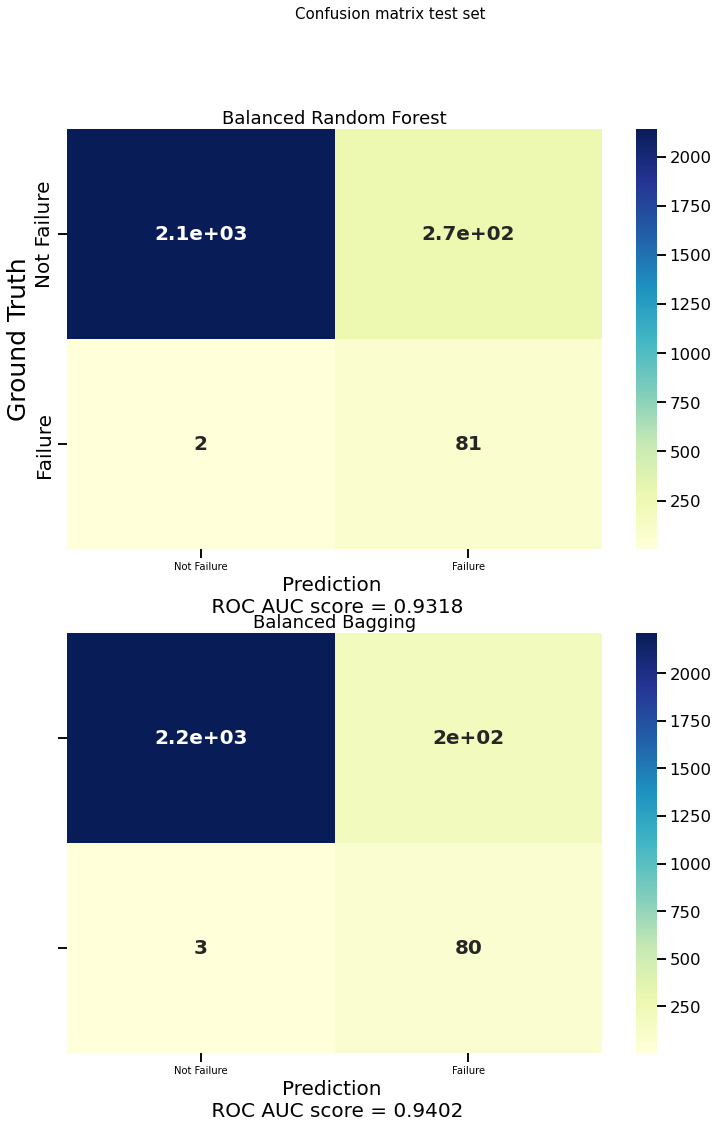

In [111]:
brfc= BalancedRandomForestClassifier(random_state=42,n_jobs=-1)

bbc= BalancedBaggingClassifier(random_state=42, n_jobs=-1)

fig,axes= plt.subplots(2,1, figsize=[12,17])
fig.suptitle('Confusion matrix test set', fontsize=15)
axes.flatten()
j=0

for model in [brfc,bbc]:
    print("Fitting", model)
    
    model=model.fit(X_train, y_train)
    
    cv=StratifiedShuffleSplit( n_splits=5, test_size=0.25)
    print(f'Cross validation roc auc :{round(cross_val_score(model, x,y, cv=cv, n_jobs=-1, scoring="roc_auc").mean(),4)}')
    
    
    y_pred=model.predict(X_test)
    
    print(f'ROC AUC test set:{round(roc_auc_score(y_test,y_pred),4)}')
    print()
    
    
    sns.set_context('talk')
    cm=confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True,cmap='YlGnBu',annot_kws={"size":20, "weight":"bold"}, ax=axes[j])
    
    
    labels = ['Not Failure', 'Failure']
    axes[j].set_xticklabels(labels, fontsize=10)
    axes[j].set_yticklabels(['',''], fontsize=10)
    axes[j].set_xlabel('Prediction \n ROC AUC score = ' + str(round(roc_auc_score(y_test, y_pred),4)), fontsize=20)
    j += 1

axes[0].set_yticklabels(labels, fontsize=20)
axes[0].set_ylabel('Ground Truth', fontsize=25)
axes[0].set_title('Balanced Random Forest')
axes[1].set_title('Balanced Bagging')

### Tuning Balanced Random Forest & Balanced Bagging

#### Randomized Search Balanced Random Forest

In [112]:
brfc = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)

params = {'n_estimators': np.arange(150, 400, 50),
               'max_depth': np.arange(10, 50, 10),
               'min_samples_split': [2, 4, 6],
               'criterion': ['gini', 'entropy'],
               'min_samples_leaf': [1, 2, 3, 4],
               'max_features': ['sqrt', 'log2']
            }

random_search = RandomizedSearchCV(brfc, params, scoring='roc_auc', cv=3,
                                   n_iter=100, random_state=42, n_jobs=-1)

random_search = random_search.fit(X_train, y_train)

In [113]:
# Best parameters from random search
print(random_search.best_params_)

# Roc auc score on test set
y_pred = random_search.predict(X_test)
print(f'ROC AUC test set: {round(roc_auc_score(y_test, y_pred),4)}')

{'n_estimators': 350, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy'}
ROC AUC test set: 0.927


#### Grid Search Balanced Random Forest

In [114]:
brfc = BalancedRandomForestClassifier(criterion='entropy', min_samples_split=4, max_features='log2', 
                                      random_state=42, n_jobs=-1)

params = {'n_estimators': [300, 350, 400],
               'max_depth': [35, 40, 45],
               'min_samples_leaf': [1, 2]
            }

grid_search = GridSearchCV(brfc, params, scoring='roc_auc', cv=cv,
                           n_jobs=-1)

grid_search = grid_search.fit(X_train, y_train)

In [115]:
# Best parameters from grid search
print(f'Best parameters: {grid_search.best_params_}')

# Roc auc score on test set
y_pred_brfc = grid_search.predict(X_test)
print(f'ROC AUC test set: {round(roc_auc_score(y_test, y_pred_brfc),4)}')

Best parameters: {'max_depth': 35, 'min_samples_leaf': 1, 'n_estimators': 400}
ROC AUC test set: 0.927


### Grid Search Balanced Bagging

In [116]:
bbc = BalancedBaggingClassifier(random_state=42, n_jobs=-1)

params = {'n_estimators': range(5,20),
         }
random_search = GridSearchCV(bbc, params, scoring='roc_auc', cv=3,
                             n_jobs=-1)

random_search = random_search.fit(X_train, y_train)

# Best parameters from random search
print(random_search.best_params_)

# Roc auc score on test set
y_pred_bbc = random_search.predict(X_test)
print(f'ROC AUC test set: {round(roc_auc_score(y_test, y_pred_bbc),4)}')

{'n_estimators': 13}
ROC AUC test set: 0.9319


In [117]:
print('Classification report Balanced Random Forest')
print(classification_report(y_test, y_pred_brfc))
print('='*53)

print('Classification report Balanced Bagging')
print(classification_report(y_test, y_pred_bbc))

Classification report Balanced Random Forest
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      2411
           1       0.23      0.96      0.37        83

    accuracy                           0.89      2494
   macro avg       0.62      0.93      0.66      2494
weighted avg       0.97      0.89      0.92      2494

Classification report Balanced Bagging
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      2411
           1       0.27      0.95      0.42        83

    accuracy                           0.91      2494
   macro avg       0.63      0.93      0.69      2494
weighted avg       0.97      0.91      0.94      2494



### Results:

- ROC AUC is higher for Balanced Bagging.
- Macro and weighted f1 score average are higher for Balanced Bagging.
- Only the recall score is a bit higher for Balanced Random Forest at 0.98 compared to 0.96 for Balanced Bagging. However, this score can be increased decreasing the decision threshold in the probability prediction.
- Balanced Bagging Classifier is selected.

### ROC curve

In [119]:
bbc = BalancedBaggingClassifier(n_estimators=19, random_state=42, n_jobs=-1)
bbc = bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)

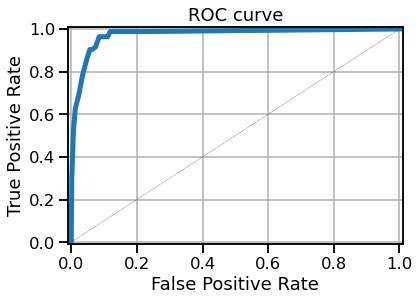

In [122]:
fig.set_size_inches(16, 8)
fig, axList = plt.subplots(ncols=1)


y_prob = bbc.predict_proba(X_test)

# ROC-AUC curve
ax = axList
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr, linewidth=5)
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

[Text(0, 0.5, 'Not Failure'), Text(0, 1.5, 'Failure')]

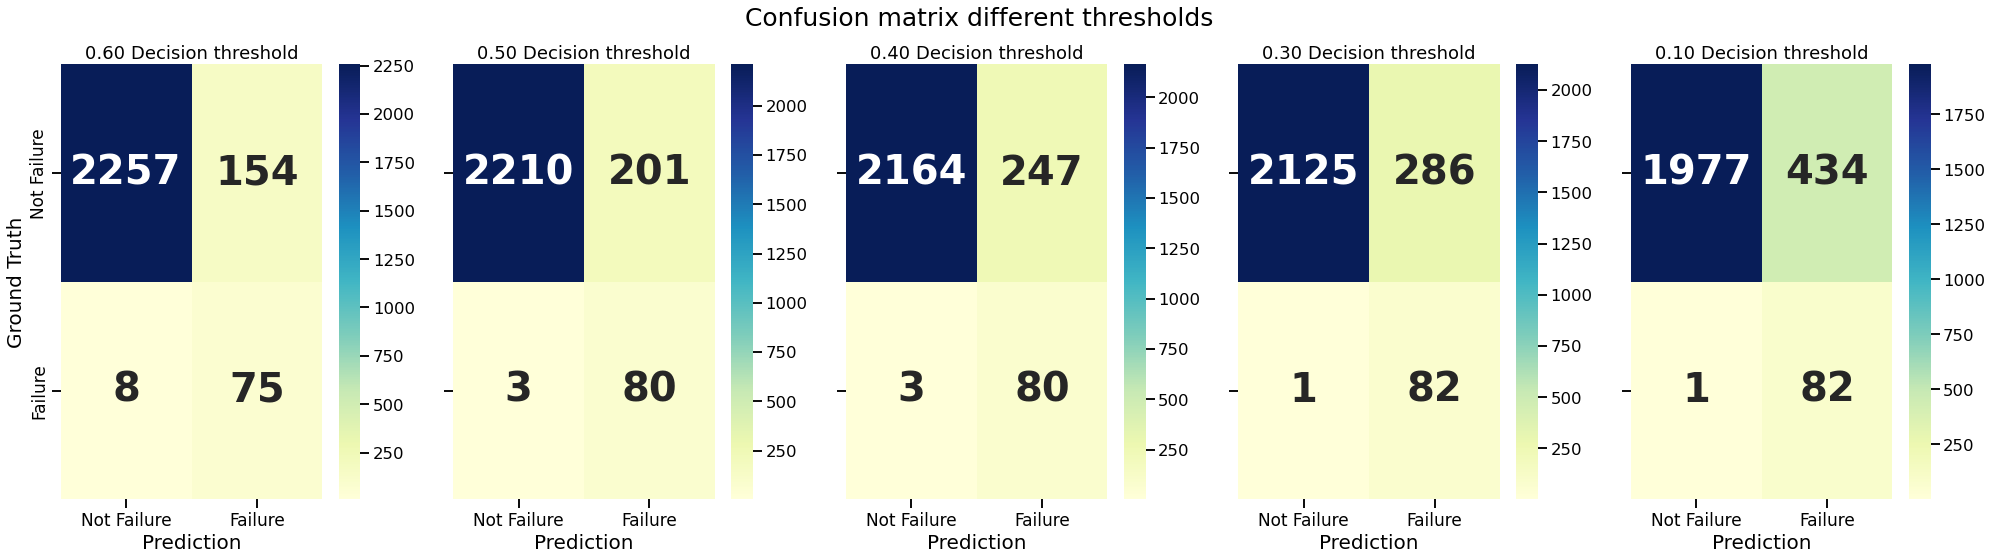

In [123]:
# Prediction probabilities with different thresholds
y_pred_dt = (bbc.predict_proba(X_test)[:,1] >= 0.1).astype(bool).astype(int)
y_pred_dt_2 = (bbc.predict_proba(X_test)[:,1] >= 0.40).astype(bool).astype(int)
y_pred_dt_3 = (bbc.predict_proba(X_test)[:,1] >= 0.30).astype(bool).astype(int)
y_pred_dt_4 = (bbc.predict_proba(X_test)[:,1] >= 0.60).astype(bool).astype(int)


# Confusion matrices with different thresholds
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_dt_2 = confusion_matrix(y_test, y_pred_dt_2)
cm_dt_3 = confusion_matrix(y_test, y_pred_dt_3)
cm_dt_4 = confusion_matrix(y_test, y_pred_dt_4)


# Plotting confusion matrices
fig, ax = plt.subplots(1,5,figsize=(34,8))
ax.flatten()
fig.suptitle('Confusion matrix different thresholds', fontsize=25)

sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', annot_kws={"size": 40, "weight": "bold"}, ax=ax[1])
sns.heatmap(cm_dt_4, annot=True, fmt='d', cmap='YlGnBu', annot_kws={"size": 40, "weight": "bold"}, ax=ax[0])
sns.heatmap(cm_dt_2, annot=True, fmt='d', cmap='YlGnBu', annot_kws={"size": 40, "weight": "bold"}, ax=ax[2])
sns.heatmap(cm_dt_3, annot=True, fmt='d', cmap='YlGnBu', annot_kws={"size": 40, "weight": "bold"}, ax=ax[3])
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='YlGnBu', annot_kws={"size": 40, "weight": "bold"}, ax=ax[4])

ax[1].set_title('0.50 Decision threshold')
ax[0].set_title('0.60 Decision threshold')
ax[2].set_title('0.40 Decision threshold')
ax[3].set_title('0.30 Decision threshold')
ax[4].set_title('0.10 Decision threshold')

labels = ['Not Failure', 'Failure']
for i in [0,1,2,3,4]:
    ax[i].set_xticklabels(labels, fontsize=17)
    ax[i].set_xlabel('Prediction', fontsize=20)
    ax[i].set_yticklabels(['',''])
    
ax[0].set_ylabel('Ground Truth', fontsize=20)
ax[0].set_yticklabels(labels, fontsize=17)

- With a 30% decision threshold we can obtained a 98.8% recall, but precision drops to around 21.5%.
- Going below 30% decision threshold makes no sense since we are getting the same recall, but lowering the precision.
- The precision score improves increasing the threshold. However, as said before, it makes no sense to lower the recall score when predicting machinery failure.
- The results obtained here were as expected, since they can be inferred by looking at the ROC AUC curve and the Recall-Precision wrt to the threshold.
- Conclusion: It seems that 0.5 decision threshold is a good trade-off here. But it would directly depend on the people using this model and what their goals are.

In [125]:
#Saving Model
import pickle
with open("BalBagging_PredMaintenance.pkl","wb") as files:
    pickle.dump(bbc,files)